In [22]:
import torch
import torch.nn as nn 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


## **Model Architecture**

In [23]:
# Simple 3 layer covolution model 
class CNN_model(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        
        # Convolution blocks
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channel, 16, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # NN block
        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*64, 512),     # 32768 -> 512
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),           # Another layer
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, 9)              # Output layer (9 waste categories)
        )
    def forward(self,x):
        X = self.feature_extractor(x)
        X = torch.flatten(X,1)
        X = self.fully_connected(X)
        
        return X
        
        

## **Data Loaders**

In [24]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import random

class AugmentedDataset(Dataset):
    """Dataset wrapper that applies multiple augmentations to create additional samples"""
    def __init__(self, dataset, num_augmentations=3, transform=None):
        self.dataset = dataset
        self.num_augmentations = num_augmentations
        self.transform = transform
        
        # Basic transform for converting to tensor if no transform provided
        self.basic_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        

        def rotate_90s():
            import random
            return transforms.Lambda(lambda img: img.rotate(random.choice([90, 180, 270])))

        # Define a set of stronger augmentation transforms with proper edge padding
        self.augmentations = [
            # Horizontal flip + 90-degree rotations
            transforms.Compose([
                transforms.RandomHorizontalFlip(p=1.0),
                rotate_90s(),
                transforms.Resize((128, 128)),  # Crop after rotation to remove borders
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Vertical flip + color jitter + 90-degree rotations
            transforms.Compose([
                transforms.RandomVerticalFlip(p=1.0),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
                rotate_90s(),
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Rotate by 90s + small affine (keeps shape when using 90-degree rotations)
            transforms.Compose([
                rotate_90s(),
                transforms.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.95, 1.05)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                transforms.CenterCrop((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            # Pure 90-degree rotation option
            transforms.Compose([
                rotate_90s(),
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]),
        ]
        
    def __len__(self):
        return len(self.dataset) * (self.num_augmentations + 1)  # Original + augmentations
    
    def __getitem__(self, idx):
        # Determine which original image to use
        original_idx = idx // (self.num_augmentations + 1)
        aug_idx = idx % (self.num_augmentations + 1)
        
        # Get original image
        img, label = self.dataset[original_idx]
        
        # If aug_idx is 0, return original with basic transform
        if aug_idx == 0:
            if self.transform:
                return self.transform(img), label
            else:
                return self.basic_transform(img), label
        
        # Otherwise, apply one of the augmentations
        # Use modulo to ensure we stay within the range of available augmentations
        transform_idx = (aug_idx - 1) % len(self.augmentations)
        transform = self.augmentations[transform_idx]
        return transform(img), label
        

# Define standard transform for basic transformations
transform_standard = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




# Create custom datasets with appropriate transforms and indices
class CustomSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
        
    def __len__(self):
        return len(self.indices)



In [25]:
# Path to the RealWaste dataset
data_dir = "/kaggle/input/realwaste/realwaste-main/RealWaste"  # Update if needed

# Load the original dataset without transforms (we'll apply them in the wrapper)
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Get dataset size
dataset_size = len(dataset)
print(f"Original dataset size: {dataset_size}")
print(f"Class names: {dataset.classes}")

# Calculate split sizes (70% train, 15% validation, 15% test)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create indices for the splits
indices = list(range(dataset_size))
random.seed(42)  # For reproducibility
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]


# Create base dataset splits
train_subset = CustomSubset(dataset, train_indices, transform=None)
train_dataset = AugmentedDataset(train_subset, num_augmentations=3, transform=transform_standard)

val_dataset = CustomSubset(dataset, val_indices, transform=transform_standard)
test_dataset = CustomSubset(dataset, test_indices, transform=transform_standard)

# Augment only the training set (4 augmentations per image + original)


# Print split information
original_train_size = len(train_subset)
augmented_train_size = len(train_dataset)
print(f"Original training samples: {original_train_size}")
print(f"Augmented training samples: {augmented_train_size} (×{augmented_train_size / original_train_size:.1f})")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Original dataset size: 4752
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Original training samples: 3326
Augmented training samples: 13304 (×4.0)
Validation samples: 712
Test samples: 714


Saving test dataset for later use

In [58]:
import os
import shutil

# Destination for saved test images (change if needed)
dest_root = "/kaggle/working/test_dataset"
os.makedirs(dest_root, exist_ok=True)

copied = 0
for idx in test_indices:
    src_path, class_idx = dataset.samples[idx]   # ImageFolder stores (path, class_idx)
    class_name = dataset.classes[class_idx]
    dst_class_dir = os.path.join(dest_root, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    base_name = os.path.basename(src_path)
    dst_path = os.path.join(dst_class_dir, base_name)

    # avoid overwrite
    if os.path.exists(dst_path):
        name, ext = os.path.splitext(base_name)
        dst_path = os.path.join(dst_class_dir, f"{name}_{idx}{ext}")

    shutil.copy2(src_path, dst_path)
    copied += 1

print(f"Saved {copied} test images to: {dest_root}")

# Create a zip archive next to the folder (result: e:\Projects\CNN\test_dataset.zip)
archive_base = os.path.join(os.path.dirname(dest_root), os.path.basename(dest_root))
archive_path = shutil.make_archive(archive_base, 'zip', root_dir=dest_root)
print(f"Created zip archive: {archive_path}")

Saved 714 test images to: /kaggle/working/test_dataset
Created zip archive: /kaggle/working/test_dataset.zip


In [26]:
def count_samples_per_class(dataset, classes):
    """
    Count the number of samples per class in a dataset
    
    Args:
        dataset: Dataset to count samples from
        classes: List of class names
    
    Returns:
        Dictionary mapping class indices to sample counts
    """
    # Initialize counters for each class
    class_counts = {i: 0 for i in range(len(classes))}
    
    # Count samples
    for _, label in dataset:
        label_idx = label.item() if isinstance(label, torch.Tensor) else label
        class_counts[label_idx] += 1
        
    # Print results
    print("\nClass distribution after augmentation:")
    print("-" * 40)
    print(f"{'Class':<10} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)
    
    total_samples = len(dataset)
    for class_idx, count in class_counts.items():
        percentage = (count / total_samples) * 100
        print(f"{class_idx:<10} {count:<10} {percentage:.2f}%")
    
    # Check for imbalance
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print("-" * 40)
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    return class_counts

# Count samples in the augmented training dataset
train_class_counts = count_samples_per_class(train_dataset, dataset.classes)




Class distribution after augmentation:
----------------------------------------
Class      Count      Percentage
----------------------------------------
0          1328       9.98%
1          1092       8.21%
2          1164       8.75%
3          2176       16.36%
4          1404       10.55%
5          1396       10.49%
6          2548       19.15%
7          936        7.04%
8          1260       9.47%
----------------------------------------
Imbalance ratio (max/min): 2.72

Original class distribution (before augmentation):


Dataset was not well balanced. So creating a balanced dataset will be better for training.

In [27]:
def create_balanced_dataset(dataset, max_samples_per_class=1000):
    """
    Create a balanced dataset by limiting the maximum number of samples per class
    
    Args:
        dataset: Original dataset
        max_samples_per_class: Maximum number of samples allowed per class
    
    Returns:
        Balanced dataset (as a torch Subset)
    """
    # Count samples per class
    class_indices = {}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label_idx = label.item() if isinstance(label, torch.Tensor) else label
        
        if label_idx not in class_indices:
            class_indices[label_idx] = []
        
        class_indices[label_idx].append(idx)
    
    # Randomly select max_samples_per_class samples for each class
    balanced_indices = []
    for label, indices in class_indices.items():
        if len(indices) > max_samples_per_class:
            # Randomly shuffle and take the first max_samples_per_class
            random.shuffle(indices)
            balanced_indices.extend(indices[:max_samples_per_class])
        else:
            # Take all samples if less than max_samples_per_class
            balanced_indices.extend(indices)
    
    # Create a subset using the balanced indices
    balanced_dataset = torch.utils.data.Subset(dataset, balanced_indices)
    
    return balanced_dataset

# Create a balanced training dataset
balanced_train_dataset = create_balanced_dataset(train_dataset, max_samples_per_class=1000)


Creating the Dataloaders

In [39]:
# Create data loaders
batch_size = 64  # Smaller batch size for larger images
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    balanced_train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Visualization of a batch

Checking training data...
Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


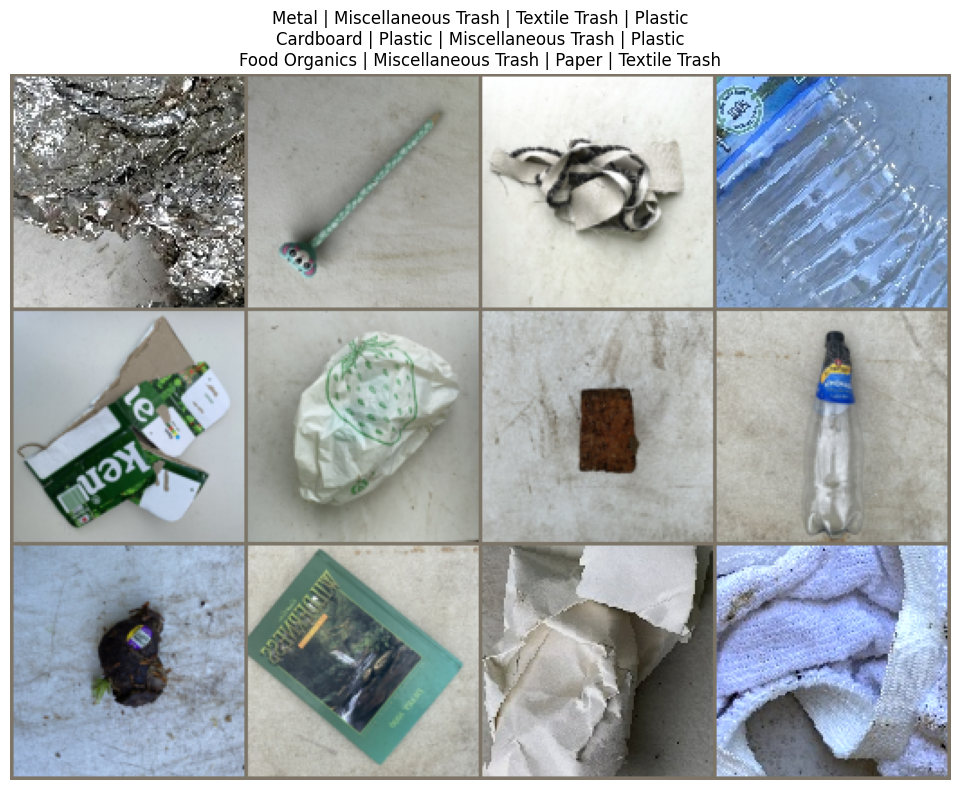

Has NaN: False
Has Inf: False
Min value: -2.1179039478302
Max value: 2.640000104904175

Checking validation data...
Batch shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


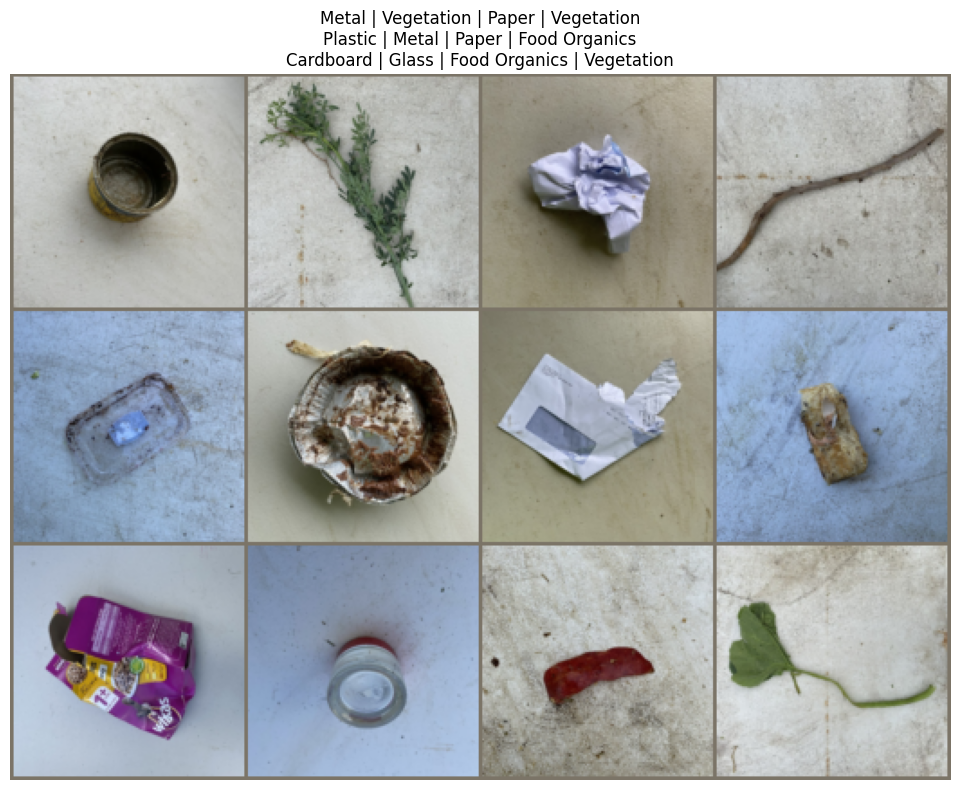

Has NaN: False
Has Inf: False
Min value: -2.1007792949676514
Max value: 2.6051416397094727


True

In [35]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def show_batch(dataloader, classes, num_images=12):
    """
    Display a batch of images with their labels from a dataloader
    
    Args:
        dataloader: PyTorch dataloader to get images from
        classes: List of class names
        num_images: Maximum number of images to display
    """
    # Get a batch of training data
    images, labels = next(iter(dataloader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    
    # Convert images back to a displayable format
    images = images[:num_images]  # Take only the first num_images
    labels = labels[:num_images]
    
    # Unnormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Create a grid of images
    img_grid = make_grid(images, nrow=4)
    img_grid = img_grid.numpy().transpose((1, 2, 0))
    
    # Unnormalize
    img_grid = std * img_grid + mean
    img_grid = np.clip(img_grid, 0, 1)
    
    # Display the images
    plt.figure(figsize=(12, 8))
    plt.imshow(img_grid)
    plt.axis('off')
    
    # Add labels as titles - fix the list issue
    # Convert each label tensor to its corresponding class name
    title_list = []
    for i in range(len(labels)):
        # Make sure to get the integer value from the tensor
        class_idx = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
        title_list.append(f"{classes[class_idx]}")
    
    # Group titles into rows of 4 for display
    title_rows = []
    for i in range(0, len(title_list), 4):
        row = title_list[i:i+4]
        title_rows.append(" | ".join(row))
    
    # Join all rows with newlines
    title = "\n".join(title_rows)
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Check if any of the tensor values are NaN or Inf
    print(f"Has NaN: {torch.isnan(images).any()}")
    print(f"Has Inf: {torch.isinf(images).any()}")
    print(f"Min value: {images.min()}")
    print(f"Max value: {images.max()}")
    
    return True

# Test the train loader
print("Checking training data...")
show_batch(train_loader, dataset.classes)

# Test the validation loader
print("\nChecking validation data...")
show_batch(val_loader, dataset.classes)

## **Training**

In [30]:
import time 
import os
from tqdm import tqdm

def Train(device, model, epochs, optimizer, scheduler, save_dir="/kaggle/working/models", name="", batch_size=None):
    
    os.makedirs(save_dir, exist_ok=True)

    loss_fn = nn.CrossEntropyLoss()
    
    # Optional: Add learning rate scheduler for better convergence
    
    EPOCHS = epochs
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(save_dir, f"best_model_{name}.pth")
    last_model_path = os.path.join(save_dir, f"last_model_{name}.pth")

    for epoch in range(EPOCHS):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Train]")
        for images, labels in tqdm(train_loader):
            # Move data to device
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # Zero gradients
            optimizer.zero_grad(set_to_none=True)
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            # Track metrics (using your approach)
            train_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            train_correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss /= len(train_dataset)
        train_acc = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        print(f"Epoch {epoch+1}/{EPOCHS} [Val]")
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                # Move data to device
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Track metrics
                val_loss += loss.item() * images.size(0)
                predicted = torch.argmax(outputs, dim=1)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss /= len(val_dataset)
        val_acc = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Save the latest model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses,
            'train_acc': train_accs,
            'val_loss': val_losses,
            'val_acc': val_accs,
            'current_lr': optimizer.param_groups[0]['lr']
        }, last_model_path)
        
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_losses,
                'train_acc': train_accs,
                'val_loss': val_losses,
                'val_acc': val_accs,
                'best_val_loss': best_val_loss,
                'current_lr': optimizer.param_groups[0]['lr']
            }, best_model_path)
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        
        # Calculate time taken for epoch
        epoch_time = time.time() - start_time
        
        # Print epoch summary (using your format)
        print(f'Epoch: {epoch+1}/{EPOCHS}, '
              f'Time: {epoch_time:.2f}s, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}, '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    print(f"Training completed. Best validation loss: {best_val_loss:.4f}")
    print(f"Best model saved to {best_model_path}")
    print(f"Last model saved to {last_model_path}")
    
    # Return training history
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'val_loss': val_losses,
        'val_acc': val_accs
    }
    
    return history, model

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## CNN Model - Adam

In [46]:
model_Adm = CNN_model(in_channel=3).to(device)

optimizer = optim.Adam(model_Adm.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
name = "Adam"

Epoch 1/25 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.05it/s]


Epoch 1/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


Saved new best model with validation loss: 1.2942
Epoch: 1/25, Time: 53.63s, Train Loss: 1.7055, Train Acc: 0.3929, Val Loss: 1.2942, Val Acc: 0.5421, LR: 0.001000
Epoch 2/25 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.65it/s]


Epoch 2/25 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.73it/s]


Saved new best model with validation loss: 1.2656
Epoch: 2/25, Time: 60.02s, Train Loss: 1.4004, Train Acc: 0.5010, Val Loss: 1.2656, Val Acc: 0.5562, LR: 0.001000
Epoch 3/25 [Train]


100%|██████████| 208/208 [00:53<00:00,  3.86it/s]


Epoch 3/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.59it/s]


Saved new best model with validation loss: 0.9060
Epoch: 3/25, Time: 56.31s, Train Loss: 1.2896, Train Acc: 0.5425, Val Loss: 0.9060, Val Acc: 0.6966, LR: 0.001000
Epoch 4/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.20it/s]


Epoch 4/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.24it/s]


Saved new best model with validation loss: 0.8825
Epoch: 4/25, Time: 51.82s, Train Loss: 1.1776, Train Acc: 0.5809, Val Loss: 0.8825, Val Acc: 0.6980, LR: 0.001000
Epoch 5/25 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.03it/s]


Epoch 5/25 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.74it/s]


Epoch: 5/25, Time: 54.04s, Train Loss: 1.1129, Train Acc: 0.6091, Val Loss: 1.2000, Val Acc: 0.5772, LR: 0.001000
Epoch 6/25 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.09it/s]


Epoch 6/25 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch: 6/25, Time: 53.45s, Train Loss: 1.0551, Train Acc: 0.6258, Val Loss: 1.0080, Val Acc: 0.6320, LR: 0.001000
Epoch 7/25 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.06it/s]


Epoch 7/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.27it/s]


Saved new best model with validation loss: 0.8612
Epoch: 7/25, Time: 53.43s, Train Loss: 0.9939, Train Acc: 0.6546, Val Loss: 0.8612, Val Acc: 0.6840, LR: 0.001000
Epoch 8/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.24it/s]


Epoch 8/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.51it/s]


Saved new best model with validation loss: 0.8055
Epoch: 8/25, Time: 51.51s, Train Loss: 0.9324, Train Acc: 0.6754, Val Loss: 0.8055, Val Acc: 0.7331, LR: 0.001000
Epoch 9/25 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.08it/s]


Epoch 9/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.00it/s]


Saved new best model with validation loss: 0.7527
Epoch: 9/25, Time: 53.26s, Train Loss: 0.9024, Train Acc: 0.6857, Val Loss: 0.7527, Val Acc: 0.7275, LR: 0.001000
Epoch 10/25 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.95it/s]


Epoch 10/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.32it/s]


Saved new best model with validation loss: 0.7477
Epoch: 10/25, Time: 54.82s, Train Loss: 0.8608, Train Acc: 0.7016, Val Loss: 0.7477, Val Acc: 0.7360, LR: 0.001000
Epoch 11/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.20it/s]


Epoch 11/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.29it/s]


Saved new best model with validation loss: 0.7062
Epoch: 11/25, Time: 51.77s, Train Loss: 0.8270, Train Acc: 0.7148, Val Loss: 0.7062, Val Acc: 0.7486, LR: 0.001000
Epoch 12/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.29it/s]


Epoch 12/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.20it/s]


Saved new best model with validation loss: 0.6917
Epoch: 12/25, Time: 50.70s, Train Loss: 0.7985, Train Acc: 0.7289, Val Loss: 0.6917, Val Acc: 0.7570, LR: 0.001000
Epoch 13/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.32it/s]


Epoch 13/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.18it/s]


Saved new best model with validation loss: 0.6558
Epoch: 13/25, Time: 50.40s, Train Loss: 0.7640, Train Acc: 0.7352, Val Loss: 0.6558, Val Acc: 0.7528, LR: 0.001000
Epoch 14/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.29it/s]


Epoch 14/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.15it/s]


Epoch: 14/25, Time: 50.51s, Train Loss: 0.7239, Train Acc: 0.7502, Val Loss: 0.8664, Val Acc: 0.7261, LR: 0.001000
Epoch 15/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.17it/s]


Epoch 15/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.31it/s]


Saved new best model with validation loss: 0.6059
Epoch: 15/25, Time: 52.05s, Train Loss: 0.6887, Train Acc: 0.7609, Val Loss: 0.6059, Val Acc: 0.7837, LR: 0.001000
Epoch 16/25 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.07it/s]


Epoch 16/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.18it/s]


Epoch: 16/25, Time: 53.02s, Train Loss: 0.6601, Train Acc: 0.7701, Val Loss: 0.6616, Val Acc: 0.7851, LR: 0.001000
Epoch 17/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.26it/s]


Epoch 17/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.22it/s]


Epoch: 17/25, Time: 50.83s, Train Loss: 0.6235, Train Acc: 0.7883, Val Loss: 0.7606, Val Acc: 0.7388, LR: 0.001000
Epoch 18/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.20it/s]


Epoch 18/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.23it/s]


Epoch: 18/25, Time: 51.43s, Train Loss: 0.6390, Train Acc: 0.7825, Val Loss: 0.7184, Val Acc: 0.7697, LR: 0.001000
Epoch 19/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.25it/s]


Epoch 19/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Epoch: 19/25, Time: 50.91s, Train Loss: 0.5975, Train Acc: 0.7956, Val Loss: 0.8643, Val Acc: 0.7247, LR: 0.000500
Epoch 20/25 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.09it/s]


Epoch 20/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.10it/s]


Epoch: 20/25, Time: 52.80s, Train Loss: 0.5297, Train Acc: 0.8222, Val Loss: 0.6297, Val Acc: 0.7935, LR: 0.000500
Epoch 21/25 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.23it/s]


Epoch 21/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.13it/s]


Epoch: 21/25, Time: 51.18s, Train Loss: 0.5007, Train Acc: 0.8310, Val Loss: 0.6587, Val Acc: 0.7851, LR: 0.000500
Epoch 22/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.25it/s]


Epoch 22/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.26it/s]


Epoch: 22/25, Time: 50.92s, Train Loss: 0.4832, Train Acc: 0.8401, Val Loss: 0.6369, Val Acc: 0.7851, LR: 0.000500
Epoch 23/25 [Train]


100%|██████████| 208/208 [00:52<00:00,  4.00it/s]


Epoch 23/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.28it/s]


Epoch: 23/25, Time: 53.94s, Train Loss: 0.4623, Train Acc: 0.8431, Val Loss: 0.7196, Val Acc: 0.7767, LR: 0.000250
Epoch 24/25 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.31it/s]


Epoch 24/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.28it/s]


Epoch: 24/25, Time: 50.21s, Train Loss: 0.4321, Train Acc: 0.8555, Val Loss: 0.6766, Val Acc: 0.7893, LR: 0.000250
Epoch 25/25 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.15it/s]


Epoch 25/25 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


Epoch: 25/25, Time: 52.15s, Train Loss: 0.4126, Train Acc: 0.8631, Val Loss: 0.6304, Val Acc: 0.7992, LR: 0.000250
Training completed. Best validation loss: 0.6059
Best model saved to models/best_model_Adam.pth
Last model saved to models/last_model_Adam.pth


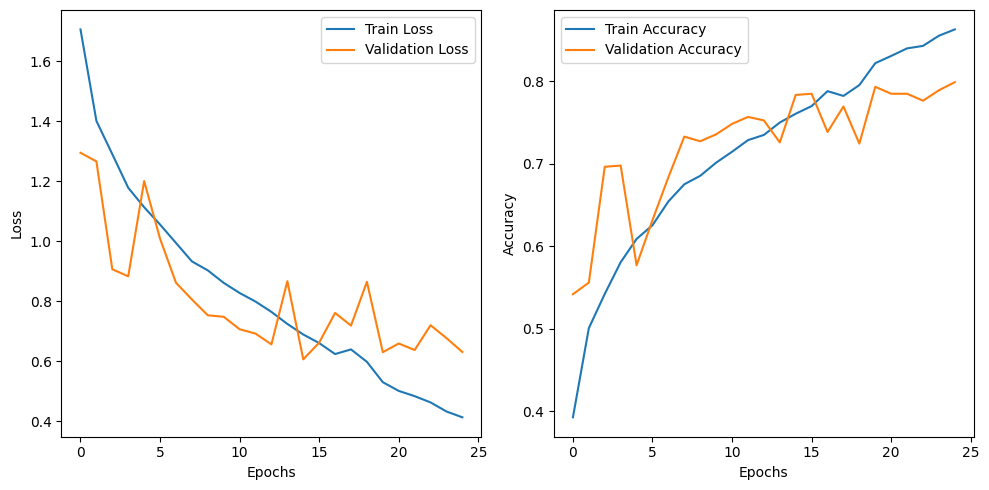

In [47]:
history, trained_model = Train(device, model_Adm, epochs=25,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## CNN Model - SGD

In [48]:
model_SGD = CNN_model(in_channel=3).to(device)


# Standard SGD configuration
optimizer = optim.SGD(
        model_SGD.parameters(),
        lr=0.01,                # Initial learning rate
        weight_decay=1e-4       # L2 regularization to prevent overfitting
    )
    

# Learning rate scheduler (reduce LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,             # Multiply LR by 0.5 when plateauing
        patience=5             # Wait 5 epochs before reducing LR
    )

name = "SGD"

Epoch 1/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.24it/s]


Epoch 1/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.44it/s]


Saved new best model with validation loss: 1.4478
Epoch: 1/40, Time: 50.85s, Train Loss: 1.8438, Train Acc: 0.3531, Val Loss: 1.4478, Val Acc: 0.5506, LR: 0.010000
Epoch 2/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.11it/s]


Epoch 2/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.01it/s]


Saved new best model with validation loss: 1.2208
Epoch: 2/40, Time: 52.47s, Train Loss: 1.5990, Train Acc: 0.4484, Val Loss: 1.2208, Val Acc: 0.5927, LR: 0.010000
Epoch 3/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.23it/s]


Epoch 3/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.97it/s]


Saved new best model with validation loss: 1.1327
Epoch: 3/40, Time: 51.10s, Train Loss: 1.4907, Train Acc: 0.4796, Val Loss: 1.1327, Val Acc: 0.6166, LR: 0.010000
Epoch 4/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.19it/s]


Epoch 4/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


Epoch: 4/40, Time: 51.39s, Train Loss: 1.4053, Train Acc: 0.5118, Val Loss: 1.2260, Val Acc: 0.5688, LR: 0.010000
Epoch 5/40 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.05it/s]


Epoch 5/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.33it/s]


Saved new best model with validation loss: 1.0932
Epoch: 5/40, Time: 53.26s, Train Loss: 1.3470, Train Acc: 0.5302, Val Loss: 1.0932, Val Acc: 0.6166, LR: 0.010000
Epoch 6/40 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.31it/s]


Epoch 6/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.24it/s]


Saved new best model with validation loss: 1.0322
Epoch: 6/40, Time: 50.15s, Train Loss: 1.2976, Train Acc: 0.5426, Val Loss: 1.0322, Val Acc: 0.6433, LR: 0.010000
Epoch 7/40 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.28it/s]


Epoch 7/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.28it/s]


Saved new best model with validation loss: 0.9208
Epoch: 7/40, Time: 50.43s, Train Loss: 1.2387, Train Acc: 0.5681, Val Loss: 0.9208, Val Acc: 0.6826, LR: 0.010000
Epoch 8/40 [Train]


100%|██████████| 208/208 [00:57<00:00,  3.62it/s]


Epoch 8/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.56it/s]


Epoch: 8/40, Time: 59.35s, Train Loss: 1.2025, Train Acc: 0.5822, Val Loss: 0.9291, Val Acc: 0.6756, LR: 0.010000
Epoch 9/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.15it/s]


Epoch 9/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch: 9/40, Time: 52.39s, Train Loss: 1.1641, Train Acc: 0.5955, Val Loss: 1.0432, Val Acc: 0.6376, LR: 0.010000
Epoch 10/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.09it/s]


Epoch 10/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.59it/s]


Saved new best model with validation loss: 0.8523
Epoch: 10/40, Time: 52.89s, Train Loss: 1.1177, Train Acc: 0.6146, Val Loss: 0.8523, Val Acc: 0.7121, LR: 0.010000
Epoch 11/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.20it/s]


Epoch 11/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.90it/s]


Saved new best model with validation loss: 0.8371
Epoch: 11/40, Time: 51.45s, Train Loss: 1.0879, Train Acc: 0.6229, Val Loss: 0.8371, Val Acc: 0.7233, LR: 0.010000
Epoch 12/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.11it/s]


Epoch 12/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.90it/s]


Saved new best model with validation loss: 0.8179
Epoch: 12/40, Time: 52.84s, Train Loss: 1.0525, Train Acc: 0.6348, Val Loss: 0.8179, Val Acc: 0.7135, LR: 0.010000
Epoch 13/40 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.93it/s]


Epoch 13/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.85it/s]


Epoch: 13/40, Time: 55.09s, Train Loss: 1.0412, Train Acc: 0.6399, Val Loss: 0.8719, Val Acc: 0.6966, LR: 0.010000
Epoch 14/40 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.97it/s]


Epoch 14/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


Epoch: 14/40, Time: 54.34s, Train Loss: 0.9966, Train Acc: 0.6591, Val Loss: 0.8716, Val Acc: 0.7008, LR: 0.010000
Epoch 15/40 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.98it/s]


Epoch 15/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


Epoch: 15/40, Time: 54.15s, Train Loss: 0.9673, Train Acc: 0.6724, Val Loss: 0.8489, Val Acc: 0.7093, LR: 0.010000
Epoch 16/40 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.06it/s]


Epoch 16/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.36it/s]


Saved new best model with validation loss: 0.7681
Epoch: 16/40, Time: 53.28s, Train Loss: 0.9650, Train Acc: 0.6694, Val Loss: 0.7681, Val Acc: 0.7121, LR: 0.010000
Epoch 17/40 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.84it/s]


Epoch 17/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.56it/s]


Epoch: 17/40, Time: 56.06s, Train Loss: 0.9162, Train Acc: 0.6855, Val Loss: 0.8231, Val Acc: 0.7065, LR: 0.010000
Epoch 18/40 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.95it/s]


Epoch 18/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.13it/s]


Epoch: 18/40, Time: 54.77s, Train Loss: 0.8974, Train Acc: 0.6893, Val Loss: 0.8372, Val Acc: 0.7079, LR: 0.010000
Epoch 19/40 [Train]


100%|██████████| 208/208 [00:55<00:00,  3.77it/s]


Epoch 19/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Epoch: 19/40, Time: 57.52s, Train Loss: 0.8724, Train Acc: 0.7020, Val Loss: 0.8943, Val Acc: 0.6784, LR: 0.010000
Epoch 20/40 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.81it/s]


Epoch 20/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.24it/s]


Saved new best model with validation loss: 0.7609
Epoch: 20/40, Time: 56.65s, Train Loss: 0.8476, Train Acc: 0.7119, Val Loss: 0.7609, Val Acc: 0.7233, LR: 0.010000
Epoch 21/40 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.05it/s]


Epoch 21/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.13it/s]


Epoch: 21/40, Time: 53.41s, Train Loss: 0.8364, Train Acc: 0.7174, Val Loss: 0.7828, Val Acc: 0.7346, LR: 0.010000
Epoch 22/40 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.05it/s]


Epoch 22/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Epoch: 22/40, Time: 53.21s, Train Loss: 0.8190, Train Acc: 0.7226, Val Loss: 0.7809, Val Acc: 0.7219, LR: 0.010000
Epoch 23/40 [Train]


100%|██████████| 208/208 [00:53<00:00,  3.86it/s]


Epoch 23/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.92it/s]


Epoch: 23/40, Time: 56.39s, Train Loss: 0.8012, Train Acc: 0.7284, Val Loss: 0.7752, Val Acc: 0.7219, LR: 0.010000
Epoch 24/40 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.02it/s]


Epoch 24/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


Saved new best model with validation loss: 0.7220
Epoch: 24/40, Time: 53.58s, Train Loss: 0.7704, Train Acc: 0.7405, Val Loss: 0.7220, Val Acc: 0.7346, LR: 0.010000
Epoch 25/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.18it/s]


Epoch 25/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.05it/s]


Epoch: 25/40, Time: 51.63s, Train Loss: 0.7618, Train Acc: 0.7482, Val Loss: 0.7889, Val Acc: 0.7065, LR: 0.010000
Epoch 26/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.14it/s]


Epoch 26/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


Epoch: 26/40, Time: 52.07s, Train Loss: 0.7315, Train Acc: 0.7535, Val Loss: 1.2098, Val Acc: 0.6166, LR: 0.010000
Epoch 27/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.17it/s]


Epoch 27/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.53it/s]


Saved new best model with validation loss: 0.7045
Epoch: 27/40, Time: 51.71s, Train Loss: 0.7406, Train Acc: 0.7488, Val Loss: 0.7045, Val Acc: 0.7528, LR: 0.010000
Epoch 28/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.21it/s]


Epoch 28/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.88it/s]


Epoch: 28/40, Time: 51.29s, Train Loss: 0.7132, Train Acc: 0.7604, Val Loss: 0.7844, Val Acc: 0.7430, LR: 0.010000
Epoch 29/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.17it/s]


Epoch 29/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.06it/s]


Epoch: 29/40, Time: 51.75s, Train Loss: 0.7042, Train Acc: 0.7651, Val Loss: 0.9799, Val Acc: 0.6994, LR: 0.010000
Epoch 30/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.14it/s]


Epoch 30/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.19it/s]


Epoch: 30/40, Time: 52.32s, Train Loss: 0.6825, Train Acc: 0.7714, Val Loss: 0.8007, Val Acc: 0.7360, LR: 0.010000
Epoch 31/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.18it/s]


Epoch 31/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.96it/s]


Epoch: 31/40, Time: 51.55s, Train Loss: 0.6663, Train Acc: 0.7744, Val Loss: 0.7348, Val Acc: 0.7402, LR: 0.010000
Epoch 32/40 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.30it/s]


Epoch 32/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.39it/s]


Epoch: 32/40, Time: 50.36s, Train Loss: 0.6651, Train Acc: 0.7762, Val Loss: 0.8556, Val Acc: 0.7135, LR: 0.010000
Epoch 33/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.11it/s]


Epoch 33/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.25it/s]


Epoch: 33/40, Time: 52.40s, Train Loss: 0.6525, Train Acc: 0.7789, Val Loss: 0.7983, Val Acc: 0.7317, LR: 0.005000
Epoch 34/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.08it/s]


Epoch 34/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Epoch: 34/40, Time: 53.41s, Train Loss: 0.5899, Train Acc: 0.8036, Val Loss: 0.7061, Val Acc: 0.7612, LR: 0.005000
Epoch 35/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.10it/s]


Epoch 35/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch: 35/40, Time: 53.01s, Train Loss: 0.5646, Train Acc: 0.8129, Val Loss: 0.7189, Val Acc: 0.7570, LR: 0.005000
Epoch 36/40 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.15it/s]


Epoch 36/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.54it/s]


Epoch: 36/40, Time: 51.83s, Train Loss: 0.5535, Train Acc: 0.8163, Val Loss: 0.7763, Val Acc: 0.7374, LR: 0.005000
Epoch 37/40 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.28it/s]


Epoch 37/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.85it/s]


Epoch: 37/40, Time: 50.41s, Train Loss: 0.5571, Train Acc: 0.8143, Val Loss: 0.7770, Val Acc: 0.7416, LR: 0.005000
Epoch 38/40 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.21it/s]


Epoch 38/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


Saved new best model with validation loss: 0.6835
Epoch: 38/40, Time: 51.21s, Train Loss: 0.5401, Train Acc: 0.8234, Val Loss: 0.6835, Val Acc: 0.7711, LR: 0.005000
Epoch 39/40 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.96it/s]


Epoch 39/40 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.56it/s]


Epoch: 39/40, Time: 54.47s, Train Loss: 0.5368, Train Acc: 0.8270, Val Loss: 0.7220, Val Acc: 0.7472, LR: 0.005000
Epoch 40/40 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.81it/s]


Epoch 40/40 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.97it/s]


Saved new best model with validation loss: 0.6829
Epoch: 40/40, Time: 56.76s, Train Loss: 0.5353, Train Acc: 0.8203, Val Loss: 0.6829, Val Acc: 0.7640, LR: 0.005000
Training completed. Best validation loss: 0.6829
Best model saved to models/best_model_SGD.pth
Last model saved to models/last_model_SGD.pth


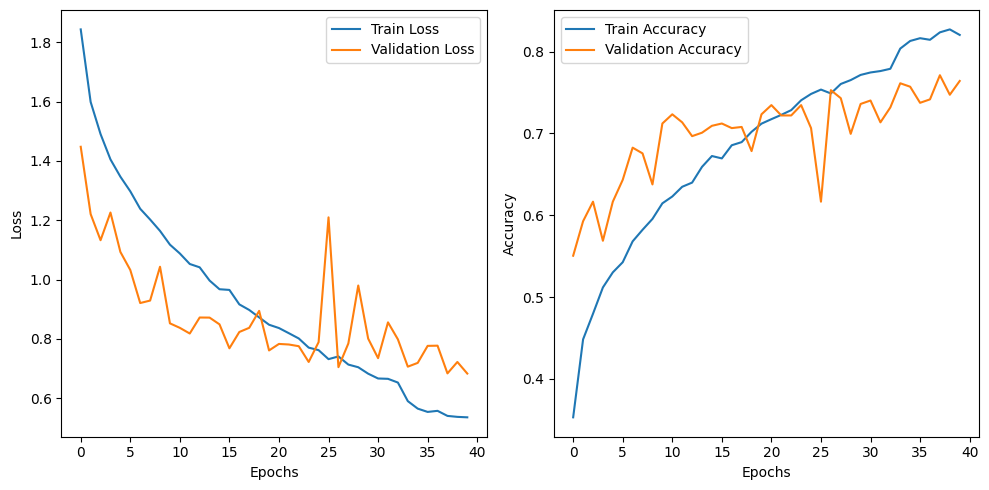

In [49]:
history, trained_model = Train(device, model_SGD, epochs=40,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## CNN Model - SGD with Momentum

In [50]:
model_SGDM = CNN_model(in_channel=3).to(device)


optimizer = optim.SGD(
        model_SGDM.parameters(),
        lr=0.01,                # Initial learning rate
        momentum=0.9,           # Momentum factor (0.9 is a common choice)
        nesterov=True,          # Using Nesterov accelerated gradient
        weight_decay=1e-4       # L2 regularization to prevent overfitting
    )
    
    # Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.2,             
        patience=3,             # Wait 5 epochs before reducing LR
        verbose=True
    )

name = "SGDM"

Epoch 1/30 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.30it/s]


Epoch 1/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.41it/s]


Saved new best model with validation loss: 1.3448
Epoch: 1/30, Time: 50.33s, Train Loss: 1.7398, Train Acc: 0.3702, Val Loss: 1.3448, Val Acc: 0.5435, LR: 0.010000
Epoch 2/30 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.31it/s]


Epoch 2/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.31it/s]


Saved new best model with validation loss: 1.0863
Epoch: 2/30, Time: 50.28s, Train Loss: 1.4737, Train Acc: 0.4754, Val Loss: 1.0863, Val Acc: 0.6390, LR: 0.010000
Epoch 3/30 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.32it/s]


Epoch 3/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.25it/s]


Epoch: 3/30, Time: 50.00s, Train Loss: 1.3482, Train Acc: 0.5187, Val Loss: 1.1529, Val Acc: 0.6081, LR: 0.010000
Epoch 4/30 [Train]


100%|██████████| 208/208 [00:47<00:00,  4.37it/s]


Epoch 4/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.43it/s]


Saved new best model with validation loss: 0.9166
Epoch: 4/30, Time: 49.66s, Train Loss: 1.2594, Train Acc: 0.5537, Val Loss: 0.9166, Val Acc: 0.6671, LR: 0.010000
Epoch 5/30 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.32it/s]


Epoch 5/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.65it/s]


Saved new best model with validation loss: 0.9144
Epoch: 5/30, Time: 50.63s, Train Loss: 1.1824, Train Acc: 0.5806, Val Loss: 0.9144, Val Acc: 0.6756, LR: 0.010000
Epoch 6/30 [Train]


100%|██████████| 208/208 [00:57<00:00,  3.61it/s]


Epoch 6/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.33it/s]


Saved new best model with validation loss: 0.8484
Epoch: 6/30, Time: 59.69s, Train Loss: 1.1245, Train Acc: 0.6014, Val Loss: 0.8484, Val Acc: 0.7093, LR: 0.010000
Epoch 7/30 [Train]


100%|██████████| 208/208 [00:47<00:00,  4.40it/s]


Epoch 7/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.38it/s]


Epoch: 7/30, Time: 49.13s, Train Loss: 1.0664, Train Acc: 0.6224, Val Loss: 0.8824, Val Acc: 0.6980, LR: 0.010000
Epoch 8/30 [Train]


100%|██████████| 208/208 [00:47<00:00,  4.39it/s]


Epoch 8/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.37it/s]


Epoch: 8/30, Time: 49.22s, Train Loss: 1.0127, Train Acc: 0.6400, Val Loss: 0.8590, Val Acc: 0.6713, LR: 0.010000
Epoch 9/30 [Train]


100%|██████████| 208/208 [00:47<00:00,  4.33it/s]


Epoch 9/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.98it/s]


Epoch: 9/30, Time: 49.91s, Train Loss: 0.9827, Train Acc: 0.6526, Val Loss: 0.8620, Val Acc: 0.6938, LR: 0.010000
Epoch 10/30 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.80it/s]


Epoch 10/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.03it/s]


Epoch: 10/30, Time: 56.62s, Train Loss: 0.9374, Train Acc: 0.6684, Val Loss: 0.8913, Val Acc: 0.6812, LR: 0.002000
Epoch 11/30 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.80it/s]


Epoch 11/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.30it/s]


Saved new best model with validation loss: 0.6850
Epoch: 11/30, Time: 56.71s, Train Loss: 0.8355, Train Acc: 0.7115, Val Loss: 0.6850, Val Acc: 0.7669, LR: 0.002000
Epoch 12/30 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.13it/s]


Epoch 12/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Saved new best model with validation loss: 0.6640
Epoch: 12/30, Time: 53.02s, Train Loss: 0.7926, Train Acc: 0.7277, Val Loss: 0.6640, Val Acc: 0.7767, LR: 0.002000
Epoch 13/30 [Train]


100%|██████████| 208/208 [00:53<00:00,  3.88it/s]


Epoch 13/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch: 13/30, Time: 55.89s, Train Loss: 0.7715, Train Acc: 0.7324, Val Loss: 0.6704, Val Acc: 0.7556, LR: 0.002000
Epoch 14/30 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.22it/s]


Epoch 14/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  7.23it/s]


Saved new best model with validation loss: 0.6612
Epoch: 14/30, Time: 51.40s, Train Loss: 0.7457, Train Acc: 0.7390, Val Loss: 0.6612, Val Acc: 0.7893, LR: 0.002000
Epoch 15/30 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.07it/s]


Epoch 15/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.36it/s]


Saved new best model with validation loss: 0.6522
Epoch: 15/30, Time: 53.40s, Train Loss: 0.7472, Train Acc: 0.7444, Val Loss: 0.6522, Val Acc: 0.7795, LR: 0.002000
Epoch 16/30 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.07it/s]


Epoch 16/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.85it/s]


Epoch: 16/30, Time: 52.99s, Train Loss: 0.7232, Train Acc: 0.7501, Val Loss: 0.6608, Val Acc: 0.7711, LR: 0.002000
Epoch 17/30 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.18it/s]


Epoch 17/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.12it/s]


Epoch: 17/30, Time: 51.95s, Train Loss: 0.7032, Train Acc: 0.7559, Val Loss: 0.6550, Val Acc: 0.7781, LR: 0.002000
Epoch 18/30 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.82it/s]


Epoch 18/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Saved new best model with validation loss: 0.6323
Epoch: 18/30, Time: 57.15s, Train Loss: 0.6869, Train Acc: 0.7665, Val Loss: 0.6323, Val Acc: 0.7865, LR: 0.002000
Epoch 19/30 [Train]


100%|██████████| 208/208 [00:59<00:00,  3.50it/s]


Epoch 19/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


Saved new best model with validation loss: 0.6288
Epoch: 19/30, Time: 62.52s, Train Loss: 0.6805, Train Acc: 0.7680, Val Loss: 0.6288, Val Acc: 0.7795, LR: 0.002000
Epoch 20/30 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.67it/s]


Epoch 20/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.84it/s]


Epoch: 20/30, Time: 58.65s, Train Loss: 0.6604, Train Acc: 0.7719, Val Loss: 0.6709, Val Acc: 0.7725, LR: 0.002000
Epoch 21/30 [Train]


100%|██████████| 208/208 [01:01<00:00,  3.40it/s]


Epoch 21/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


Epoch: 21/30, Time: 63.46s, Train Loss: 0.6523, Train Acc: 0.7772, Val Loss: 0.7111, Val Acc: 0.7612, LR: 0.002000
Epoch 22/30 [Train]


100%|██████████| 208/208 [00:57<00:00,  3.59it/s]


Epoch 22/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.63it/s]


Epoch: 22/30, Time: 60.69s, Train Loss: 0.6384, Train Acc: 0.7795, Val Loss: 0.6603, Val Acc: 0.7809, LR: 0.002000
Epoch 23/30 [Train]


100%|██████████| 208/208 [00:58<00:00,  3.57it/s]


Epoch 23/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.07it/s]


Epoch: 23/30, Time: 60.87s, Train Loss: 0.6384, Train Acc: 0.7827, Val Loss: 0.6750, Val Acc: 0.7711, LR: 0.000400
Epoch 24/30 [Train]


100%|██████████| 208/208 [00:57<00:00,  3.60it/s]


Epoch 25/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.82it/s]


Epoch: 25/30, Time: 60.03s, Train Loss: 0.5745, Train Acc: 0.8049, Val Loss: 0.6392, Val Acc: 0.7992, LR: 0.000400
Epoch 26/30 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.65it/s]


Epoch 26/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.32it/s]


Epoch: 26/30, Time: 59.41s, Train Loss: 0.5756, Train Acc: 0.8064, Val Loss: 0.6456, Val Acc: 0.8020, LR: 0.000400
Epoch 27/30 [Train]


100%|██████████| 208/208 [01:01<00:00,  3.39it/s]


Epoch 27/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


Epoch: 27/30, Time: 63.59s, Train Loss: 0.5750, Train Acc: 0.8052, Val Loss: 0.6438, Val Acc: 0.7978, LR: 0.000080
Epoch 28/30 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.70it/s]


Epoch 28/30 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.32it/s]


Epoch: 28/30, Time: 58.26s, Train Loss: 0.5712, Train Acc: 0.8091, Val Loss: 0.6389, Val Acc: 0.7992, LR: 0.000080
Epoch 29/30 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.66it/s]


Epoch 29/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch: 29/30, Time: 59.54s, Train Loss: 0.5683, Train Acc: 0.8098, Val Loss: 0.6332, Val Acc: 0.8006, LR: 0.000080
Epoch 30/30 [Train]


100%|██████████| 208/208 [00:58<00:00,  3.54it/s]


Epoch 30/30 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Saved new best model with validation loss: 0.6285
Epoch: 30/30, Time: 61.44s, Train Loss: 0.5616, Train Acc: 0.8144, Val Loss: 0.6285, Val Acc: 0.8048, LR: 0.000080
Training completed. Best validation loss: 0.6285
Best model saved to models/best_model_SGDM.pth
Last model saved to models/last_model_SGDM.pth


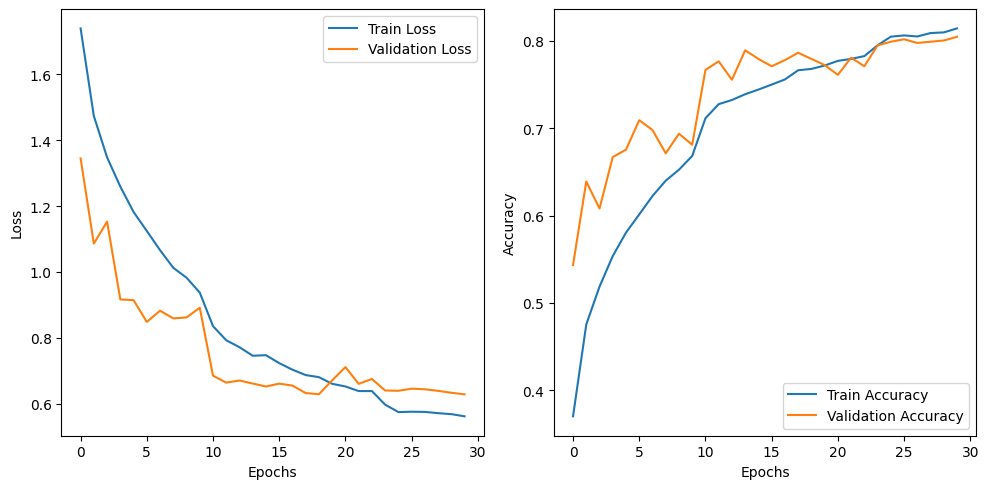

In [51]:
history, trained_model = Train(device, model_SGDM, epochs=30,  optimizer=optimizer, scheduler=scheduler, name=name, save_dir="models")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Resnet 50 Model

In [55]:
from torchvision import models

model_ft = models.resnet50(pretrained=True)

# Freeze earlier layers
for param in model_ft.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(dataset.classes))  # number of classes in dataset

model_ft = model_ft.to(device)


# Only parameters of final layer are being optimized
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=5e-4)

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
name = "Resnet_50"

Epoch 1/20 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.65it/s]


Epoch 1/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.64it/s]


Saved new best model with validation loss: 0.9233
Epoch: 1/20, Time: 59.61s, Train Loss: 1.2646, Train Acc: 0.5761, Val Loss: 0.9233, Val Acc: 0.6812, LR: 0.000500
Epoch 2/20 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.84it/s]


Epoch 2/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Saved new best model with validation loss: 0.8733
Epoch: 2/20, Time: 57.32s, Train Loss: 0.9532, Train Acc: 0.6742, Val Loss: 0.8733, Val Acc: 0.6868, LR: 0.000500
Epoch 3/20 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.82it/s]


Epoch 3/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.61it/s]


Saved new best model with validation loss: 0.8290
Epoch: 3/20, Time: 56.81s, Train Loss: 0.8878, Train Acc: 0.6952, Val Loss: 0.8290, Val Acc: 0.7065, LR: 0.000500
Epoch 4/20 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.79it/s]


Epoch 4/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.96it/s]


Saved new best model with validation loss: 0.7740
Epoch: 4/20, Time: 57.40s, Train Loss: 0.8321, Train Acc: 0.7108, Val Loss: 0.7740, Val Acc: 0.7163, LR: 0.000500
Epoch 5/20 [Train]


100%|██████████| 208/208 [00:52<00:00,  3.95it/s]


Epoch 5/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Saved new best model with validation loss: 0.7708
Epoch: 5/20, Time: 54.93s, Train Loss: 0.8249, Train Acc: 0.7147, Val Loss: 0.7708, Val Acc: 0.7289, LR: 0.000500
Epoch 6/20 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.19it/s]


Epoch 6/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.09it/s]


Saved new best model with validation loss: 0.7260
Epoch: 6/20, Time: 52.13s, Train Loss: 0.7954, Train Acc: 0.7270, Val Loss: 0.7260, Val Acc: 0.7261, LR: 0.000500
Epoch 7/20 [Train]


100%|██████████| 208/208 [00:53<00:00,  3.90it/s]


Epoch 7/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.47it/s]


Epoch: 7/20, Time: 55.41s, Train Loss: 0.7745, Train Acc: 0.7307, Val Loss: 0.7332, Val Acc: 0.7360, LR: 0.000500
Epoch 8/20 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.71it/s]


Epoch 8/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.36it/s]


Epoch: 8/20, Time: 58.27s, Train Loss: 0.7573, Train Acc: 0.7393, Val Loss: 0.7536, Val Acc: 0.7205, LR: 0.000500
Epoch 9/20 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.10it/s]


Epoch 9/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.61it/s]


Saved new best model with validation loss: 0.7232
Epoch: 9/20, Time: 53.03s, Train Loss: 0.7494, Train Acc: 0.7420, Val Loss: 0.7232, Val Acc: 0.7317, LR: 0.000500
Epoch 10/20 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.15it/s]


Epoch 10/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  6.00it/s]


Saved new best model with validation loss: 0.7042
Epoch: 10/20, Time: 52.58s, Train Loss: 0.7317, Train Acc: 0.7466, Val Loss: 0.7042, Val Acc: 0.7317, LR: 0.000500
Epoch 11/20 [Train]


100%|██████████| 208/208 [00:51<00:00,  4.05it/s]


Epoch 11/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch: 11/20, Time: 54.10s, Train Loss: 0.7290, Train Acc: 0.7480, Val Loss: 0.7290, Val Acc: 0.7289, LR: 0.000500
Epoch 12/20 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.22it/s]


Epoch 12/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.75it/s]


Epoch: 12/20, Time: 51.36s, Train Loss: 0.7059, Train Acc: 0.7587, Val Loss: 0.7081, Val Acc: 0.7331, LR: 0.000500
Epoch 13/20 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.26it/s]


Epoch 13/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.51it/s]


Saved new best model with validation loss: 0.6898
Epoch: 13/20, Time: 51.18s, Train Loss: 0.6956, Train Acc: 0.7572, Val Loss: 0.6898, Val Acc: 0.7303, LR: 0.000500
Epoch 14/20 [Train]


100%|██████████| 208/208 [00:49<00:00,  4.24it/s]


Epoch 14/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.89it/s]


Saved new best model with validation loss: 0.6814
Epoch: 14/20, Time: 51.54s, Train Loss: 0.6893, Train Acc: 0.7619, Val Loss: 0.6814, Val Acc: 0.7472, LR: 0.000500
Epoch 15/20 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.10it/s]


Epoch 15/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.13it/s]


Epoch: 15/20, Time: 53.35s, Train Loss: 0.6858, Train Acc: 0.7641, Val Loss: 0.6977, Val Acc: 0.7472, LR: 0.000500
Epoch 16/20 [Train]


100%|██████████| 208/208 [00:50<00:00,  4.12it/s]


Epoch 16/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.65it/s]


Saved new best model with validation loss: 0.6692
Epoch: 16/20, Time: 52.73s, Train Loss: 0.6770, Train Acc: 0.7708, Val Loss: 0.6692, Val Acc: 0.7528, LR: 0.000500
Epoch 17/20 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.26it/s]


Epoch 17/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.70it/s]


Saved new best model with validation loss: 0.6659
Epoch: 17/20, Time: 51.14s, Train Loss: 0.6696, Train Acc: 0.7737, Val Loss: 0.6659, Val Acc: 0.7542, LR: 0.000500
Epoch 18/20 [Train]


100%|██████████| 208/208 [00:48<00:00,  4.26it/s]


Epoch 18/20 [Val]


100%|██████████| 12/12 [00:01<00:00,  6.73it/s]


Saved new best model with validation loss: 0.6482
Epoch: 18/20, Time: 51.09s, Train Loss: 0.6564, Train Acc: 0.7753, Val Loss: 0.6482, Val Acc: 0.7584, LR: 0.000500
Epoch 19/20 [Train]


100%|██████████| 208/208 [00:54<00:00,  3.83it/s]


Epoch 19/20 [Val]


100%|██████████| 12/12 [00:03<00:00,  3.38it/s]


Saved new best model with validation loss: 0.6426
Epoch: 19/20, Time: 58.40s, Train Loss: 0.6503, Train Acc: 0.7767, Val Loss: 0.6426, Val Acc: 0.7739, LR: 0.000500
Epoch 20/20 [Train]


100%|██████████| 208/208 [00:56<00:00,  3.68it/s]


Epoch 20/20 [Val]


100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch: 20/20, Time: 58.92s, Train Loss: 0.6487, Train Acc: 0.7750, Val Loss: 0.6767, Val Acc: 0.7402, LR: 0.000500
Training completed. Best validation loss: 0.6426
Best model saved to models/best_model_Resnet_50.pth
Last model saved to models/last_model_Resnet_50.pth


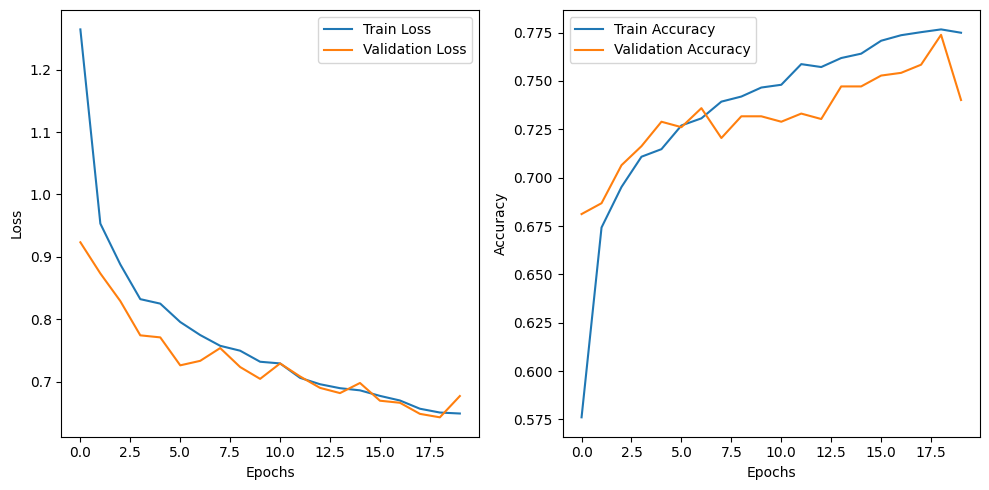

In [56]:
history, trained_model = Train(device, model_ft, epochs=20,  optimizer=optimizer_ft, scheduler=scheduler, name=name, save_dir="models")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
!zip -r models.zip /kaggle/working/models

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/best_model_SGD.pth (deflated 8%)
  adding: kaggle/working/models/best_model_Adam.pth (deflated 8%)
  adding: kaggle/working/models/best_model_SGDM.pth (deflated 7%)
  adding: kaggle/working/models/last_model_Resnet_50.pth (deflated 7%)
  adding: kaggle/working/models/last_model_SGD.pth (deflated 8%)
  adding: kaggle/working/models/last_model_SGDM.pth (deflated 7%)
  adding: kaggle/working/models/best_model_Resnet_50.pth (deflated 7%)
  adding: kaggle/working/models/last_model_Adam.pth (deflated 8%)
